## Pre-requisites

Before running this notebook, you should have already used the `extract_features.py` script to extract features from models trained on DHS data. You should have the following structure under the `outputs/` directory:

```
dhs_ooc/
    DHS_OOC_A_ms_samescaled_b64_fc01_conv01_lr0001/
        features.npz
    ...
    DHS_OOC_E_rgb_same_b64_fc001_conv001_lr0001/
        features.npz
dhs_incountry/
    DHS_Incountry_A_ms_samescaled_b64_fc01_conv01_lr001/
        features.npz
    ...
    DHS_Incountry_E_nl_random_b64_fc01_conv01_lr001/
        features.npz
transfer/
    transfer_nlcenter_ms_b64_fc001_conv001_lr0001/
        features.npz
    transfer_nlcenter_rgb_b64_fc001_conv001_lr0001/
        features.npz
        

TODO: update when keep-frac models are added
```

## Instructions

This notebook essentially performs fine-tuning of the final-layer of the Resnet-18 models. However, instead of directly fine-tuning the Resnet-18 models in TensorFlow, we train ridge-regression models using the extracted features. We take this approach for two reasons:

1. It is easier to perform leave-one-group-out ("logo") cross-validated ridge regression using scikit-learn, as opposed to TensorFlow. For out-of-country (OOC) experiments, the left-out group is the test country. For in-country experiments, the left-out group is the test split.
2. We can concatenate the 512-dim features from the RGB/MS CNN models with the 512-dim features from the NL CNN models to form a larger 1024-dim feature vector capturing RGB/MS + NL imagery information. We do this instead of training a CNN with the MS+NL imagery stacked together as an input because we found it to result in better performance.

Because of the extensive cross-validation, each "logo" CV run may take ~2-4 hours. In total, this notebook may take upwards of 15 hours to complete.

After you complete this notebook, use the `model_analysis/dhs_ooc.ipynb` and `model_analysis/dhs_incountry.ipynb` (TODO) notebooks to analyze the final performance of the fine-tuned Resnet-18 models.

## Imports and Constants

In [1]:
%cd '/hdd/home/abenabbes/Ali-a/'
%load_ext autoreload
%autoreload 2
%matplotlib inline
!pwd

/home/abenabbes/Ali-a
/home/abenabbes/Ali-a


In [3]:
!pip install matplotlib

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from __future__ import annotations

from collections.abc import Iterable
import os
import pickle

import numpy as np
import pandas as pd

from batchers import dataset_constants
from models.linear_model import ridge_cv
from utils.general import load_npz

In [3]:
FOLDS = ['A', 'B', 'C', 'D', 'E']
SPLITS = ['train', 'val', 'test']
label = 'longevity'
OUTPUTS_ROOT_DIR = f'/root/logs/{label}'
INPUTS_ROOT_DIR = f'/root/final_ex/{label}'
COUNTRIES = dataset_constants.DHS_COUNTRIES

KEEPS = [0.05, 0.1, 0.25, 0.5]
SEEDS = [123, 456, 789]

## Load data

In [4]:
MODEL_DIRS = {
    #Incountry models - NightLight
    
    'incountry_resnet_nl_A':'DHS_Incountry_A_nl_random_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_nl_B':'DHS_Incountry_B_nl_random_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_nl_C':'DHS_Incountry_C_nl_random_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_nl_D':'DHS_Incountry_D_nl_random_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_nl_E':'DHS_Incountry_E_nl_random_b64_fc1_conv1.0_lr001',
    
    #Incountry models - MultiSpectral
    
    'incountry_resnet_ms_A':'DHS_Incountry_A_ms_samescaled_200_b64_fc01_conv01_lr001',
    'incountry_resnet_ms_B':'DHS_Incountry_B_ms_samescaled_200_b64_fc1_conv1_lr001',
    'incountry_resnet_ms_C':'DHS_Incountry_C_ms_samescaled_200_b64_fc1.0_conv1.0_lr0001',
    'incountry_resnet_ms_D':'DHS_Incountry_D_ms_samescaled_200_b64_fc001_conv1.0_lr0001',
    'incountry_resnet_ms_E':'DHS_Incountry_E_ms_samescaled_200_b64_fc001_conv001_lr0001',
    
}

`country_labels` is a `np.ndarray` that shows which country each cluster belongs to. Countries are indexed by their position in `dataset_constants.DHS_COUNTRIES`.
```python
array([ 0,  0,  0, ..., 22, 22, 22])
```

`incountry_group_labels` is a `np.ndarray` that shows which "test" fold each cluster belongs to. The first cluster belongs to the "test" split of fold "B" (folds here are 0-indexed).
```python
array([1, 1, 4, ..., 1, 0, 3])
```

In [5]:
countries=["brazil"]

print(len(countries))

1


In [6]:
FOLDS = ["A", "B", "C", "D", "E"]
indicators = ['income','longevity','literacy']
for label in indicators:
    df = pd.read_csv('/root/Datasets/SelectedClusters/dataset_clean.csv', float_precision='high', index_col=False)
    labels = df[label].to_numpy(dtype=np.float32)
    print(labels)

[0.62848234 0.52086043 0.58054364 ... 0.39499784 0.5965954  0.42051378]
[0.76833475 0.7585517  0.78156924 ... 0.77831715 0.7430432  0.8276139 ]
[0.9635056  0.90334564 0.92679846 ... 0.8781472  0.9634995  0.8127828 ]


In [7]:
indicators = ['income','longevity','literacy']
for label in indicators:
    print(f'for label {label}')
    df = pd.read_csv('/root/Datasets/SelectedClusters/dataset_clean.csv', float_precision='high', index_col=False)
    labels = df[label].to_numpy(dtype=np.float32)
    print(labels)
    print(len(labels))
    locs = df[['lat', 'lon']].to_numpy(dtype=np.float32)
    country_labels = df['country'].map(countries.index).to_numpy()
    print(country_labels)

with open('/root/Datasets/SelectedClusters/dhs_incountry_co.pkl', 'rb') as f:
    incountry_folds = pickle.load(f)
incountry_group_labels = np.zeros(len(df), dtype=np.int64)
for i, fold in enumerate(FOLDS):
    test_indices = incountry_folds[fold]['test']
    print(test_indices)
    incountry_group_labels[test_indices] = i
    print(i)


for label income
[0.62848234 0.52086043 0.58054364 ... 0.39499784 0.5965954  0.42051378]
20438
[0 0 0 ... 0 0 0]
for label longevity
[0.76833475 0.7585517  0.78156924 ... 0.77831715 0.7430432  0.8276139 ]
20438
[0 0 0 ... 0 0 0]
for label literacy
[0.9635056  0.90334564 0.92679846 ... 0.8781472  0.9634995  0.8127828 ]
20438
[0 0 0 ... 0 0 0]
[    1     2     3 ... 20433 20434 20437]
0
[   22    23    42 ... 20414 20416 20424]
1
[    0     4     5 ... 20418 20419 20429]
2
[   27    29    32 ... 20423 20435 20436]
3
[   13    14    30 ... 20426 20431 20432]
4


In [8]:
label = 'longevity'

print(f'for label {label}')
df = pd.read_csv('/root/Datasets/SelectedClusters/dataset_clean.csv', float_precision='high', index_col=False)
npz = load_npz(f'/root/Datasets/SelectedClusters/dhs_co_{label}.npz')
labels = npz['labels']
print(labels)
print(len(labels))
locs = npz['locs']
country_labels = df['country'].map(countries.index).to_numpy()
print(country_labels)

with open('/root/Datasets/SelectedClusters/dhs_incountry_co.pkl', 'rb') as f:
    incountry_folds = pickle.load(f)
incountry_group_labels = np.zeros(len(df), dtype=np.int64)
for i, fold in enumerate(FOLDS):
    test_indices = incountry_folds[fold]['test']
    print(test_indices)
    incountry_group_labels[test_indices] = i
    print(i)

for label longevity
image_hists: dtype=int64, shape=(20438, 8, 102)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
nls_center: dtype=float32, shape=(20438,)
nls_mean: dtype=float32, shape=(20438,)
[0.85707    0.6969067  0.5205223  ... 0.7833033  0.68333334 0.71666664]
20438
[0 0 0 ... 0 0 0]
[    1     2     3 ... 20433 20434 20437]
0
[   22    23    42 ... 20414 20416 20424]
1
[    0     4     5 ... 20418 20419 20429]
2
[   27    29    32 ... 20423 20435 20436]
3
[   13    14    30 ... 20426 20431 20432]
4


## Incountry

In [9]:
def ridgecv_incountry_wrapper(model_name: str, savedir: str) -> None:
    '''
    Args
    - model_name: str, corresponds to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    features_dict = {}
    for f in FOLDS:
        model_fold_name = f'{model_name}_{f}'
        print(model_fold_name)
        model_dir = MODEL_DIRS[model_fold_name]
        npz_path = os.path.join(INPUTS_ROOT_DIR, 'dhsincountry', model_dir, 'features.npz')
        print(labels)
        npz = load_npz(npz_path, check={'labels': labels})
        features_dict[f] = npz['features']

    ridge_cv(
        features=features_dict,
        labels=labels,
        group_labels=incountry_group_labels,
        group_names=FOLDS,
        do_plot=True,
        savedir=savedir,
        save_weights=True,
        verbose=True)

incountry_resnet_nl_A
[0.85707    0.6969067  0.5205223  ... 0.7833033  0.68333334 0.71666664]
features: dtype=float32, shape=(20438, 512)
preds: dtype=float32, shape=(20438,)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
incountry_resnet_nl_B
[0.85707    0.6969067  0.5205223  ... 0.7833033  0.68333334 0.71666664]
features: dtype=float32, shape=(20438, 512)
preds: dtype=float32, shape=(20438,)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
incountry_resnet_nl_C
[0.85707    0.6969067  0.5205223  ... 0.7833033  0.68333334 0.71666664]
features: dtype=float32, shape=(20438, 512)
preds: dtype=float32, shape=(20438,)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
incountry_resnet_nl_D
[0.85707    0.6969067  0.5205223  ... 0.7833033  0.68333334 0.71666664]
features: dtype=float32, shape=(20438, 512)
pred

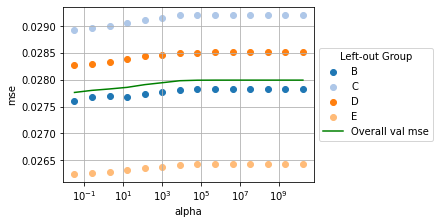

best val mse: 0.028, best alpha: 0.03125, test mse: 0.026
Group: B
Alpha: 17179869184.0 (14/14)
best val mse: 0.027, best alpha: 0.03125, test mse: 0.028
Group: C
Alpha: 17179869184.0 (14/14)
best val mse: 0.027, best alpha: 0.03125, test mse: 0.029
Group: D
Alpha: 17179869184.0 (14/14)
best val mse: 0.027, best alpha: 0.03125, test mse: 0.028
Group: E
Alpha: 17179869184.0 (14/14)
best val mse: 0.028, best alpha: 0.03125, test mse: 0.026
saving test preds to: /root/logs/longevity/resnet_nl/test_preds.npz
saving ridge_weights to: /root/logs/longevity/resnet_nl/ridge_weights.npz


In [10]:
model_name = 'incountry_resnet_nl'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'resnet_nl')
ridgecv_incountry_wrapper(model_name, savedir)

incountry_resnet_ms_A
[0.85707    0.6969067  0.5205223  ... 0.7833033  0.68333334 0.71666664]
features: dtype=float32, shape=(20438, 512)
preds: dtype=float32, shape=(20438,)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
incountry_resnet_ms_B
[0.85707    0.6969067  0.5205223  ... 0.7833033  0.68333334 0.71666664]
features: dtype=float32, shape=(20438, 512)
preds: dtype=float32, shape=(20438,)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
incountry_resnet_ms_C
[0.85707    0.6969067  0.5205223  ... 0.7833033  0.68333334 0.71666664]
features: dtype=float32, shape=(20438, 512)
preds: dtype=float32, shape=(20438,)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
incountry_resnet_ms_D
[0.85707    0.6969067  0.5205223  ... 0.7833033  0.68333334 0.71666664]
features: dtype=float32, shape=(20438, 512)
pred

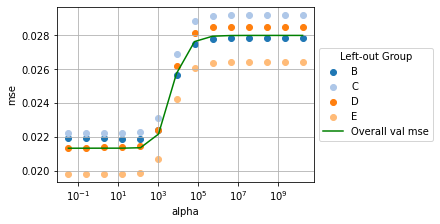

best val mse: 0.021, best alpha: 0.03125, test mse: 0.022
Group: B
Alpha: 17179869184.0 (14/14)
best val mse: 0.026, best alpha: 0.03125, test mse: 0.026
Group: C
Alpha: 17179869184.0 (14/14)
best val mse: 0.022, best alpha: 2.0, test mse: 0.024
Group: D
Alpha: 17179869184.0 (14/14)
best val mse: 0.022, best alpha: 0.03125, test mse: 0.023
Group: E
Alpha: 17179869184.0 (14/14)
best val mse: 0.021, best alpha: 2.0, test mse: 0.021
saving test preds to: /root/logs/longevity/resnet_ms/test_preds.npz
saving ridge_weights to: /root/logs/longevity/resnet_ms/ridge_weights.npz


In [12]:
model_name = 'incountry_resnet_ms'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'resnet_ms')
ridgecv_incountry_wrapper(model_name, savedir)

### Concatenated MS + NL Features

In [13]:
def ridgecv_incountry_concat_wrapper(model_names: Iterable[str], savedir: str) -> None:
    '''
    Args
    - model_names: list of str, correspond to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    features_dict = {}
    for i, f in enumerate(FOLDS):
        concat_features = []  # list of np.array, each shape [N, D_i]
        for model_name in model_names:
            print(model_name)
            model_dir = MODEL_DIRS[f'{model_name}_{f}']
            npz_path = os.path.join(INPUTS_ROOT_DIR, 'dhsincountry', model_dir, 'features.npz')
            npz = load_npz(npz_path, check={'labels': labels})
            concat_features.append(npz['features'])
        concat_features = np.concatenate(concat_features, axis=1)  # shape [N, D_1 + ... + D_m]
        features_dict[f] = concat_features

    ridge_cv(
        features=features_dict,
        labels=labels,
        group_labels=incountry_group_labels,
        group_names=FOLDS,
        do_plot=True,
        savedir=savedir,
        save_weights=True,
        verbose=True)

incountry_resnet_ms
features: dtype=float32, shape=(20438, 512)
preds: dtype=float32, shape=(20438,)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
incountry_resnet_nl
features: dtype=float32, shape=(20438, 512)
preds: dtype=float32, shape=(20438,)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
incountry_resnet_ms
features: dtype=float32, shape=(20438, 512)
preds: dtype=float32, shape=(20438,)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
incountry_resnet_nl
features: dtype=float32, shape=(20438, 512)
preds: dtype=float32, shape=(20438,)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
incountry_resnet_ms
features: dtype=float32, shape=(20438, 512)
preds: dtype=float32, shape=(20438,)
labels: dtype=float32, shape=(20438,)
locs: dtype=f

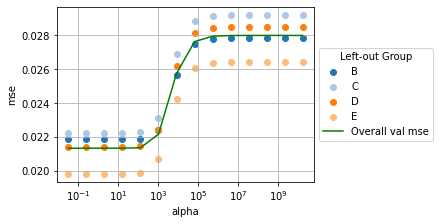

best val mse: 0.021, best alpha: 0.03125, test mse: 0.022
Group: B
Alpha: 17179869184.0 (14/14)
best val mse: 0.026, best alpha: 0.03125, test mse: 0.026
Group: C
Alpha: 17179869184.0 (14/14)
best val mse: 0.022, best alpha: 16.0, test mse: 0.024
Group: D
Alpha: 17179869184.0 (14/14)
best val mse: 0.022, best alpha: 0.03125, test mse: 0.023
Group: E
Alpha: 17179869184.0 (14/14)
best val mse: 0.021, best alpha: 2.0, test mse: 0.021
saving test preds to: /root/logs/longevity/resnet_msnl_concat/test_preds.npz
saving ridge_weights to: /root/logs/longevity/resnet_msnl_concat/ridge_weights.npz


In [14]:
model_names = ['incountry_resnet_ms', 'incountry_resnet_nl']
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'resnet_msnl_concat')
ridgecv_incountry_concat_wrapper(model_names, savedir)

### Transfer

In [ ]:
DHS_Incountry_A_ms_samescaled_b64_fc01_conv01_lr001

In [ ]:
def ridgecv_incountry_transfer_wrapper(model_name: str, savedir: str) -> None:
    '''
    Args
    - model_name: str, corresponds to keys in MODEL_DIRS (without the fold suffix)
    - savedir: str, path to directory for saving ridge regression weights and predictions
    '''
    model_dir = MODEL_DIRS[model_name]
    npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'transfer', model_dir, 'features.npz')
    features = load_npz(npz_path, check={'labels': labels})['features']
    ridge_cv(
        features=features,
        labels=labels,
        group_labels=incountry_group_labels,
        group_names=FOLDS,
        do_plot=True,
        savedir=savedir,
        save_weights=False)

In [ ]:
model_name = 'transfer_resnet_ms'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'transfer', MODEL_DIRS[model_name])
ridgecv_incountry_transfer_wrapper(model_name, savedir)

In [ ]:
model_name = 'transfer_resnet_rgb'
savedir = os.path.join(OUTPUTS_ROOT_DIR, 'transfer', MODEL_DIRS[model_name])
ridgecv_incountry_transfer_wrapper(model_name, savedir)